# Illegal zoning
_they made the character of our neighboorhoods illegal_

Waltham, like a lot of other cities with zoning codes, has a bit of a silly problem.
You see, the zoning is so restrictive in some places, that the existing structures could not be rebuilt.
Everything would have to go through a special permit, which is time consuming and expensive. You can imagine a lot of people
wouldn't even bother and just build where the zoning is easier.

What's the scale of the problem?

In [19]:
from dvc.api import DVCFileSystem
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
import geopandas as geo_pd
from dbfread import DBF


# plotting
import seaborn as sns

%matplotlib inline

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")

## Load shapefiles for buildings, zones, and parcels as well as the tax assessments data

In [4]:
with fs.open(f"data/gis/L3_SHP_M308_WALTHAM.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/L3_SHP_M308_Waltham/M308TaxPar_CY22_FY23.shp"
    property_shapefiles_df = geo_pd.read_file(shp_path)

    assessments_table = DBF(f"../../data/gis/L3_SHP_M308_Waltham/M308Assess_CY22_FY23.dbf", load=True)
    assessments_df = pd.DataFrame([dict(r) for r in assessments_table.records])

In [6]:
assessments_df.head()

,PROP_ID,LOC_ID,BLDG_VAL,LAND_VAL,OTHER_VAL,TOTAL_VAL,FY,LOT_SIZE,LS_DATE,LS_PRICE,...,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,STORIES,NUM_ROOMS,LOT_UNITS,CAMA_ID,TOWN_ID
0,R063 002 0017,F_734012_2963106,257400,392000,7300,656700,2023,0.11,20080930,385000,...,1930,1352,1,1352,COLONIAL,2,6,A,28,308
1,R015 004 0001,F_730830_2973583,236500,388900,0,625400,2023,0.22,20080422,1,...,1962,1931,1,1931,RANCH,1,5,A,46,308
2,R015 003 0017,F_730659_2973534,171600,382200,5200,559000,2023,0.21,19770301,39500,...,1952,1756,1,1756,CONVENTIONAL,2,7,A,55,308
3,R015 005 0001,F_730718_2973342,400200,391900,6100,798200,2023,0.23,20061205,1,...,1952,2922,1,2922,COLONIAL,2,6,A,64,308
4,R015 006 0006,F_730548_2973294,369300,382600,2700,754600,2023,0.21,20050315,1,...,1952,1792,1,1792,COLONIAL,2,8,A,73,308


In [5]:
property_shapefiles_df.head()

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,NO_MATCH,TOWN_ID,geometry
0,106.284365,416.922636,R079 001 0038,F_720118_2954451,FEE,079,ASSESS,None,20111130,OK,N,308,"POLYGON ((219510.406 900516.563, 219505.564 90..."
1,124.114669,875.162824,R079 001 0036,F_720144_2954524,FEE,079,ASSESS,None,20111130,OK,N,308,"POLYGON ((219521.229 900544.743, 219512.577 90..."
2,89.087299,415.368750,R080 002 0014,F_722474_2954539,FEE,080,ASSESS,None,20111130,OK,N,308,"POLYGON ((220212.276 900527.633, 220199.657 90..."
3,190.134403,1076.273990,R079 001 0037,F_720055_2954540,FEE,079,ASSESS,None,20111130,OK,N,308,"POLYGON ((219481.807 900560.359, 219483.941 90..."
4,102.019748,615.329243,R079 001 0033,F_720183_2954604,FEE,079,ASSESS,None,20111130,OK,N,308,"POLYGON ((219530.434 900568.770, 219524.316 90..."


In [48]:
shp_path = f"../../data/Buildings/Buildings.shp"
buildings_df = geo_pd.read_file(shp_path)
# most of this data isn't very useful to us
buildings_df = buildings_df[["geometry"]]

# assign MassGIS CRS
buildings_df.to_crs(property_shapefiles_df.crs, inplace=True)
buildings_df.head()

,geometry
0,"POLYGON ((219179.561 908215.757, 219174.404 90..."
1,"POLYGON ((219207.717 908210.616, 219205.988 90..."
2,"POLYGON ((219181.783 908206.625, 219176.641 90..."
3,"POLYGON ((219192.485 908186.819, 219192.235 90..."
4,"POLYGON ((219235.340 908191.010, 219235.404 90..."


## The zoning rules table

This data comes from `Sec. 4.11. Table of Dimensional Regulations` of the city zoning code.

https://ecode360.com/attachment/WA1697/WA1697-Ze%20Table%20of%20Dimentional%20Regulations.pdf

I selected rows that apply to multi-family housing when the table had a more complex case defined per-use type.

Units are in feet for the most part, except for stories, FAR, lot coverage %, min open space % and max dwelling unit / acre values.

In [49]:
zoning_rules_df = pd.read_csv("../../data/zoning_rules_table.csv")
zoning_rules_df.head()

,District,front setback,side setback,rear setback,height,stories,FAR by right,max lot coverage,min open space,lot area,max DUA,lot frontage
0,RA1,40,20,40,35,2.5,NaN,0.20,NaN,20000.0,NaN,100
1,RA2,40,20,40,35,2.5,NaN,0.20,NaN,15000.0,NaN,80
2,RA3,25,15,30,35,2.5,NaN,0.25,NaN,9600.0,NaN,70
3,RA4,25,15,30,35,2.5,NaN,0.25,NaN,7000.0,NaN,60
4,RB,15,10,30,40,3.0,NaN,0.30,NaN,6000.0,NaN,60


In [50]:
with fs.open(f"data/gis/WalthamZoning.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/WalthamZoning/WalthamZoning.shp"
    zoning_df = geo_pd.read_file(shp_path)
    
# set the waltham zoning crs to match the MassGIS one
zoning_df.to_crs(property_shapefiles_df.crs, inplace=True)

In [51]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geometry"] = property_shapefiles_df["geometry"]
property_shapefiles_df["geometry"] = property_shapefiles_df.centroid
zoned_parcels_df = property_shapefiles_df.sjoin(zoning_df, how="left", predicate="within")
#zoned_parcels_df.drop(axis="columns", labels=["index_right", "geometry"], inplace=True)

#zoned_parcels_df.rename(columns={"NAME": "ZONE", "parcel_geometry": "geometry"}, inplace=True)
zoned_parcels_df.rename(columns={"NAME": "ZONE"}, inplace=True)
#zoned_parcels_df = zoned_parcels_df[["LOC_ID", "geometry", "ZONE"]]

In [52]:
zoned_parcels_df.head(100)

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE_left,PLAN_ID,LAST_EDIT,BND_CHK,...,SHAPE_LENG,ORDINANCE,EDITOR,CHANGE_DAT,SOURCE_right,PLAN_NAME,SHAPE_STAr,SHAPE_STLe,SHAPE_ST_1,SHAPE_ST_2
0,106.284365,416.922636,R079 001 0038,F_720118_2954451,FEE,079,ASSESS,None,20111130,OK,...,7250.804361,None,None,None,None,None,2.455726e+06,7234.425935,2.455726e+06,7234.425935
1,124.114669,875.162824,R079 001 0036,F_720144_2954524,FEE,079,ASSESS,None,20111130,OK,...,7250.804361,None,None,None,None,None,2.455726e+06,7234.425935,2.455726e+06,7234.425935
2,89.087299,415.368750,R080 002 0014,F_722474_2954539,FEE,080,ASSESS,None,20111130,OK,...,5795.703172,None,None,None,None,None,7.042411e+05,5787.687201,7.042411e+05,5787.687201
3,190.134403,1076.273990,R079 001 0037,F_720055_2954540,FEE,079,ASSESS,None,20111130,OK,...,7250.804361,None,None,None,None,None,2.455726e+06,7234.425935,2.455726e+06,7234.425935
4,102.019748,615.329243,R079 001 0033,F_720183_2954604,FEE,079,ASSESS,None,20111130,OK,...,7250.804361,None,None,None,None,None,2.455726e+06,7234.425935,2.455726e+06,7234.425935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,140.753564,926.484875,R074 010 0024,F_720051_2955612,FEE,074,ASSESS,None,20111130,OK,...,7250.804361,None,None,None,None,None,2.455726e+06,7234.425935,2.455726e+06,7234.425935
96,78.642570,149.570778,R076 019 0014,F_725027_2955685,FEE,076,ASSESS,None,20111130,OK,...,4850.731263,None,None,None,None,None,8.810008e+05,4851.632894,8.810008e+05,4851.632894
97,40.077397,92.505258,R075 004 0012,F_722237_2955701,FEE,075,ASSESS,None,20111130,OK,...,5795.703172,None,None,None,None,None,7.042411e+05,5787.687201,7.042411e+05,5787.687201
98,227.494175,2919.489552,R079 004 0003,F_721106_2955606,FEE,079,ASSESS,None,20111130,OK,...,5144.696406,None,None,None,None,None,1.121533e+06,5202.056168,1.121533e+06,5202.056168


In [53]:
zoned_parcels_df.columns

Index(['SHAPE_Leng', 'SHAPE_Area', 'MAP_PAR_ID', 'LOC_ID', 'POLY_TYPE',
       'MAP_NO', 'SOURCE_left', 'PLAN_ID', 'LAST_EDIT', 'BND_CHK', 'NO_MATCH',
       'TOWN_ID', 'geometry', 'parcel_geometry', 'centroid', 'index_right',
       'ZONE', 'CODE', 'SHAPE_LENG', 'ORDINANCE', 'EDITOR', 'CHANGE_DAT',
       'SOURCE_right', 'PLAN_NAME', 'SHAPE_STAr', 'SHAPE_STLe', 'SHAPE_ST_1',
       'SHAPE_ST_2'],
      dtype='object')

In [57]:
# assign buildings to zones
zoned_buildings_df = buildings_df.sjoin(zoning_df, how="left", predicate="within")
zoned_buildings_df = zoned_buildings_df[["geometry", "NAME"]]
zoned_buildings_df.rename(columns={"NAME": "ZONE"}, inplace=True)
zoned_buildings_df.head()

,geometry,ZONE
0,"POLYGON ((219179.561 908215.757, 219174.404 90...",RA2
1,"POLYGON ((219207.717 908210.616, 219205.988 90...",RA2
2,"POLYGON ((219181.783 908206.625, 219176.641 90...",RA2
3,"POLYGON ((219192.485 908186.819, 219192.235 90...",RA2
4,"POLYGON ((219235.340 908191.010, 219235.404 90...",RA2


## Non-compliance

Parcels might not comply if they're too small. Structures wouldn't comply based on their shape or closeness to each other. FAR and setback violations turn out to be pretty hard to calculate so we'll skip that for now.

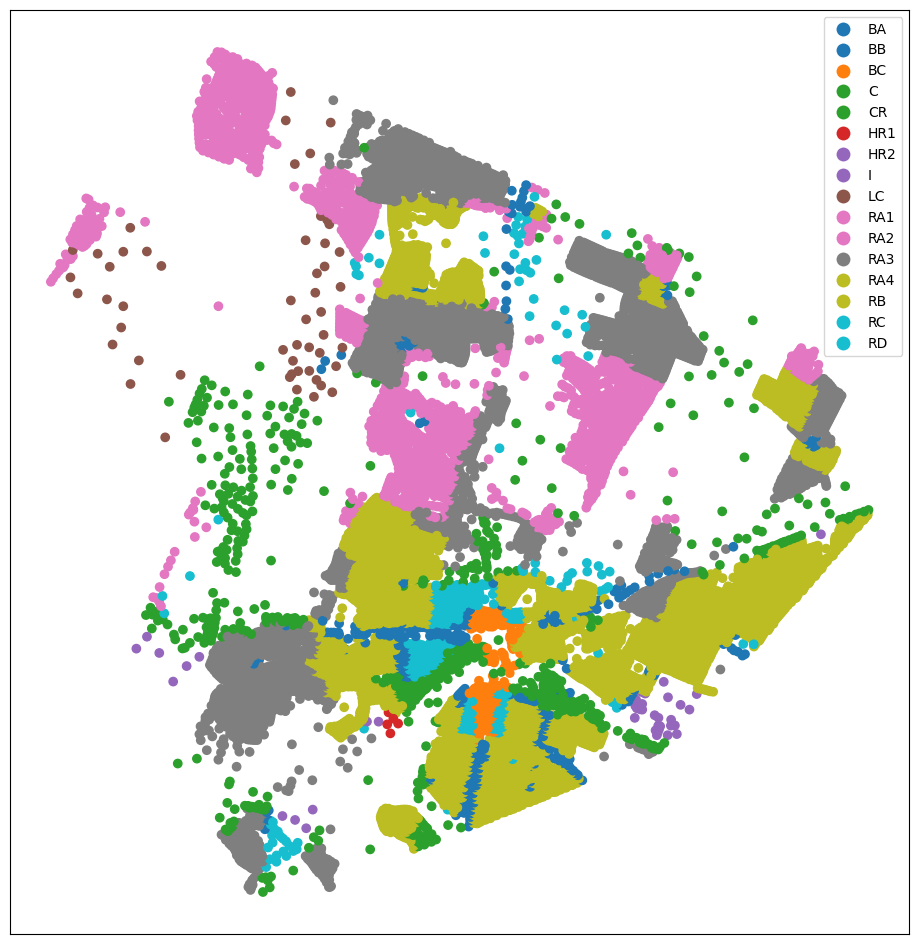

In [58]:
ax = zoned_parcels_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

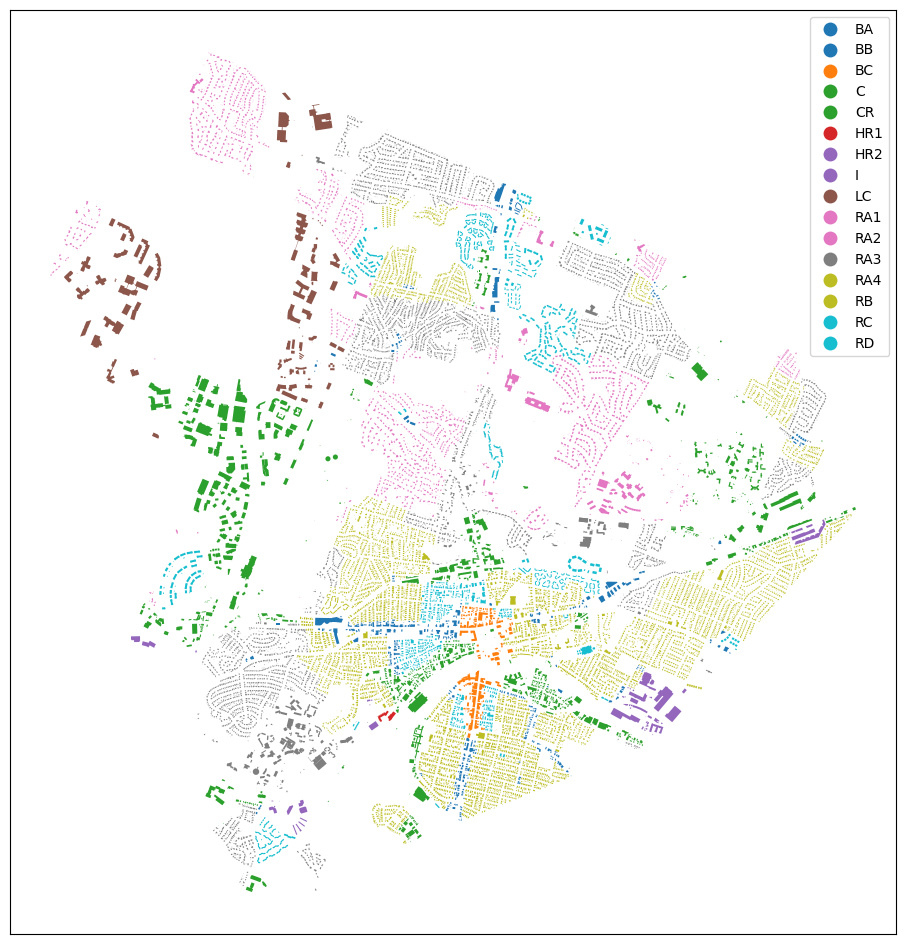

In [59]:
ax = zoned_buildings_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)